In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import mlflow
import mlflow.sklearn
import scipy.stats as scs
import statsmodels.api as sm

import logging

import dvc.api

In [ ]:
Format = '%(levelname)s %(asctime)s - %(message)s'
logging.basicConfig(filename= r'lstm.log',
level =logging.INFO,
format = Format)
logger = logging.getLogger()

In [2]:
#Get url from DVC

path = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\PharmaceuticalSalesPrediction\data\salestime.csv'
repo = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\PharmaceuticalSalesPrediction'
version = 'v4'

data_url = dvc.api.get_url(

    path = path,
    repo = repo,
    rev = version

)

In [3]:
data = pd.read_csv(data_url,sep=',')
data

,Date,Sales
0,2015-07-31,5263
1,2015-07-30,5020
2,2015-07-29,4782
3,2015-07-28,5011
4,2015-07-27,6102
...,...,...
1017204,2013-01-05,4771
1017205,2013-01-04,4540
1017206,2013-01-03,4297
1017207,2013-01-02,3697


In [4]:
data = data.groupby('Date')['Sales'].sum()
data = data.to_frame()
data 

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593
...,...
2015-07-27,10707292
2015-07-28,9115073
2015-07-29,8499962


In [5]:
scaler = MinMaxScaler()
scaler.fit(data.Sales.values.reshape([-1, 1]))
datascaled = scaler.transform(data.Sales.values.reshape(-1, 1))
data['SalesScaled'] = datascaled
data.tail(10)

,Sales,SalesScaled
Date,,
2015-07-22,6110388,0.387288
2015-07-23,6687068,0.424430
2015-07-24,6601325,0.418908
2015-07-25,6021666,0.381574
2015-07-26,285865,0.012149
2015-07-27,10707292,0.683360
2015-07-28,9115073,0.580810
2015-07-29,8499962,0.541193
2015-07-30,8798854,0.560443


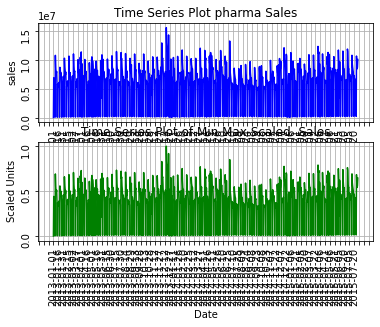

In [33]:
M = 100
xticks = ticker.MaxNLocator(M)
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(data.index, data.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('sales')
ax1.title.set_text('Time Series Plot pharma Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(data.index, data.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled  Sales')
ax2.grid(True)
plt.show()

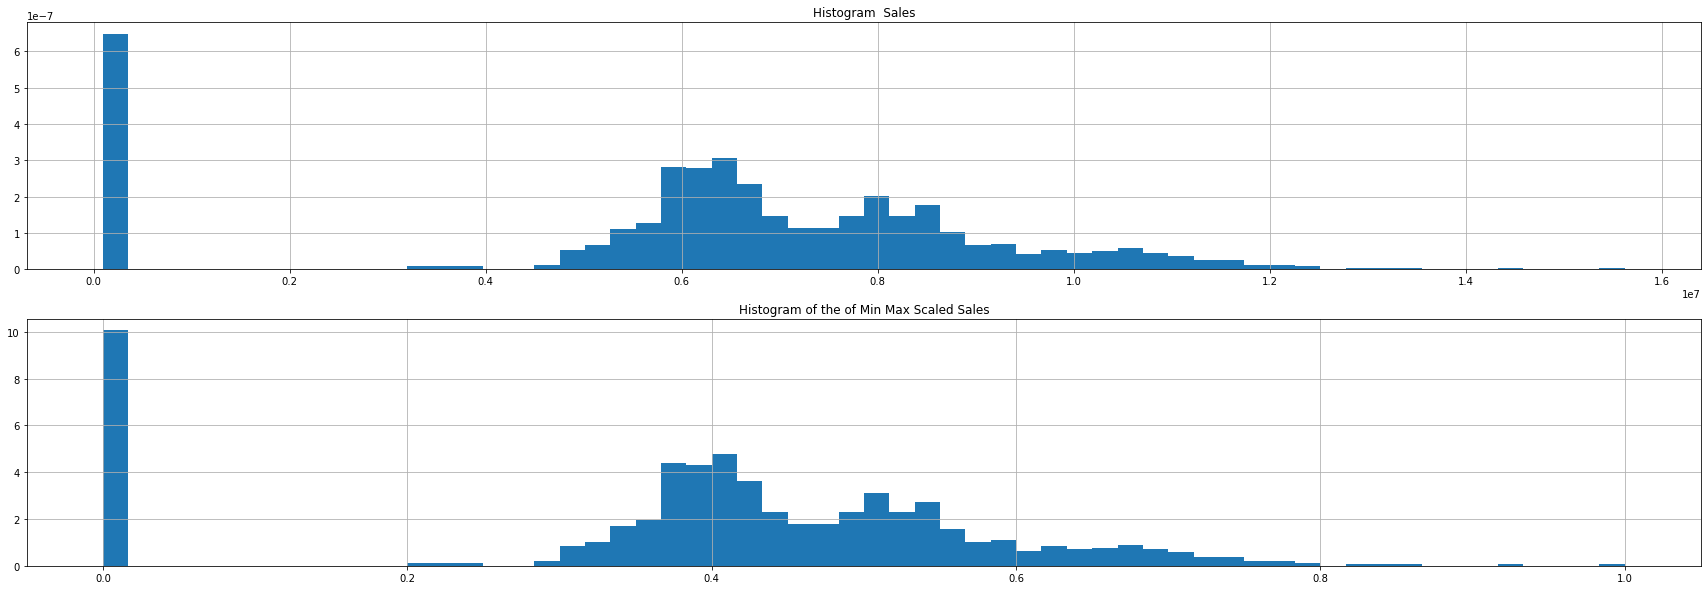

In [9]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(data.Sales, density=True, bins=60)
ax1.title.set_text('Histogram  Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(data.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

Augmented Dickey-Fuller test (ADF)
ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.
Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

In [17]:
X = data['Sales'].values

In [18]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.761615
p-value: 0.000064
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [19]:
result_log = adfuller(np.log(X))
print('ADF Statistic: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.404705
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [20]:
SIZE = len(data.SalesScaled)
WINDOW_SIZE = 30
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 100

In [21]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (882, 1)
Shape of the validation set date series:  (60, 1)

Shape of the training set logarithm of sales series:  (882,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (60,)


In [22]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [23]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [24]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 0.0967 - val_loss: 0.1048
Epoch 2/100
1/1 [==============================] - 0s 219ms/step - loss: 0.0938 - val_loss: 0.1017
Epoch 3/100
1/1 [==============================] - 0s 214ms/step - loss: 0.0911 - val_loss: 0.0986
Epoch 4/100
1/1 [==============================] - 0s 202ms/step - loss: 0.0883 - val_loss: 0.0956
Epoch 5/100
1/1 [==============================] - 0s 203ms/step - loss: 0.0857 - val_loss: 0.0926
Epoch 6/100
1/1 [==============================] - 0s 239ms/step - loss: 0.0830 - val_loss: 0.0897
Epoch 7/100
1/1 [==============================] - 0s 236ms/step - loss: 0.0805 - val_loss: 0.0869
Epoch 8/100
1/1 [==============================] - 0s 209ms/step - loss: 0.0779 - val_loss: 0.0840
Epoch 9/100
1/1 [==============================] - 0s 258ms/step - loss: 0.0755 - val_loss: 0.0813
Epoch 10/100
1/1 [==============================] - 0s 209ms/step - loss: 0.0730 - val_loss: 0.0786
Epoch 11/1

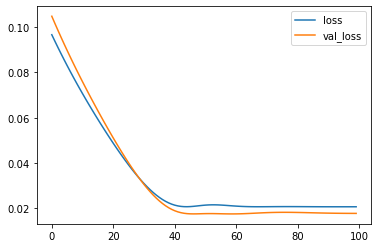

In [27]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [28]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [29]:
Forecast = model_forecast(model, data.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

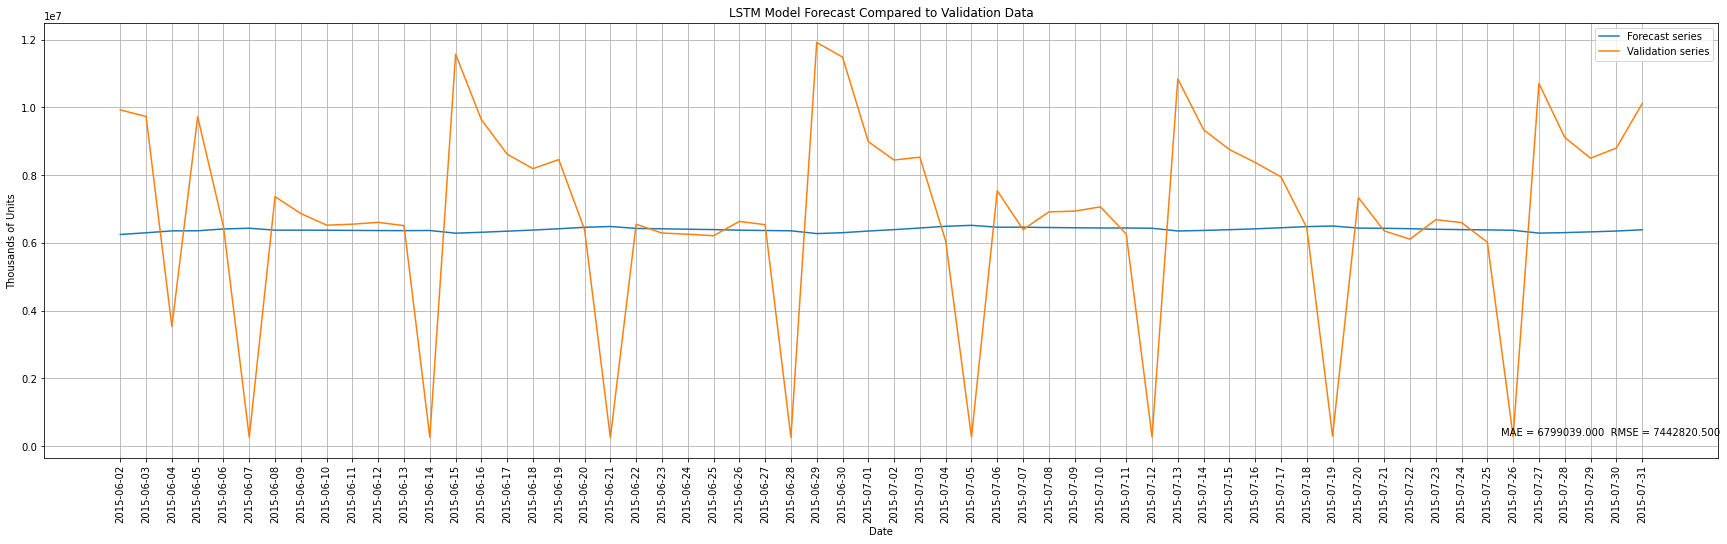

In [30]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [31]:
print(textstr)

MAE = 6799039.000  RMSE = 7442820.500
